#Downloading the Dataset

Installing Opendatasets Library

In [1]:
!pip install opendatasets

Downloading dataset from Kaggle

In [2]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/vivek468/superstore-dataset-final")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kairavnandi
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/vivek468/superstore-dataset-final


100%|██████████| 550k/550k [00:00<00:00, 273MB/s]

#Importing Required Libraries

In [3]:
#for SQL Queries
import sqlite3 as sql

#for data reading, preprocessing and visualisation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#for ignoring warning
import warnings
warnings.filterwarnings("ignore")

#Reading Data

Converting Dataset into its Respective Dataframe

In [4]:
df = pd.read_csv("/content/superstore-dataset-final/Sample - Superstore.csv", encoding = 'ISO-8859-1')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


Gathering Information about Dataframe

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

#Using SQL for Data Aggregation

Importing Data into SQL

In [6]:
conn = sql.connect('superstore.db')
df.to_sql('superstore_data', conn, if_exists = 'replace', index = False)

9994

Cleaning Missing/Null Records

In [7]:
conn.execute("""
DELETE
FROM superstore_data
WHERE
  [Order ID] IS NULL OR
  [Customer Name] IS NULL;
""")
conn.commit()

cursor = conn.cursor()
cursor.execute("SELECT COUNT(*) FROM superstore_data;")
count = cursor.fetchone()[0]
print("Number of records in SQL database after handling null values:", count)

Number of records in SQL database after handling null values: 9994


Calculating Profit Margins by Category and Sub-category

In [8]:
profits_query = """
SELECT
    Category,
    [Sub-Category],
    SUM(Profit) AS Total_Profit,
    SUM(Sales) AS Total_Sales,
    SUM(Profit) * 100.0 / SUM(Sales) AS Profit_Margin
FROM
    superstore_data
GROUP BY
    Category, [Sub-Category]
ORDER BY
    Profit_Margin DESC;
"""

profits_df = pd.read_sql_query(profits_query, conn)
profits_df.head()

,Category,Sub-Category,Total_Profit,Total_Sales,Profit_Margin
0,Office Supplies,Labels,5546.2540,12486.312,44.418672
1,Office Supplies,Paper,34053.5693,78479.206,43.391837
2,Office Supplies,Envelopes,6964.1767,16476.402,42.267582
3,Technology,Copiers,55617.8249,149528.030,37.195585
4,Office Supplies,Fasteners,949.5182,3024.280,31.396504


Closing the connection

In [9]:
conn.close()

#Data Encoding

In [10]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

#Feature Engineering

Adding column for Seasons

In [11]:
df['Season'] = df['Order Date'].apply(lambda x: 'Winter' if x.month in [12, 1, 2] else
                                                'Spring' if x.month in [3, 4, 5] else
                                                'Summer' if x.month in [6, 7, 8] else
                                                'Fall')

Calculating Inventory Days or Days Sales of Inventory (DSI)

In [12]:
beginning_inventory = df.groupby('Product ID')['Quantity'].first()
ending_inventory = df.groupby('Product ID')['Quantity'].last()
average_inventory = (beginning_inventory + ending_inventory) / 2

df['COGS'] = df['Sales'] - df['Profit']

df = df.merge(average_inventory.rename("Average Inventory"), on = "Product ID")
df['Inventory Days'] = (df['Average Inventory'] / df['COGS']) * 365

df = df.drop(['COGS', 'Average Inventory'], axis = 1)

Calculating Profitability

In [13]:
df['Profitability'] = (df['Profit'] / df['Sales']) * 100

In [14]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Season,Inventory Days,Profitability
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,Fall,4.146853,16.00
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,Fall,1.780981,30.00
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,Summer,164.868492,47.00
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,Fall,0.816793,-40.00
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,Fall,119.511777,11.25


Correlation between Inventory Days and Profitability

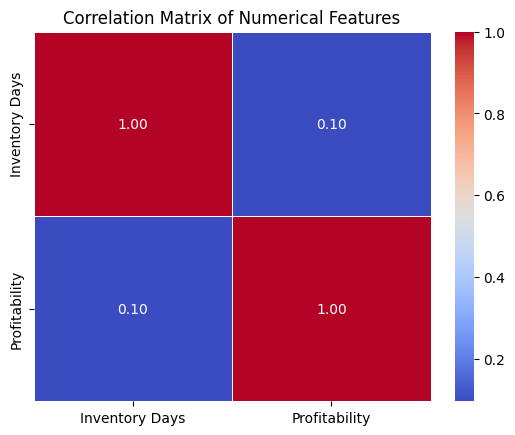

In [15]:
corr_matrix = df[['Inventory Days', 'Profitability']].corr()

sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm', fmt = ".2f", linewidths = .5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

#Downloading Dataframe into CSV file

In [16]:
df.to_csv('final_superstore.csv', index = False)

#Identify slow-moving and overstocked items


Using boxplot on Inventory Days to see the number of slow-moving items

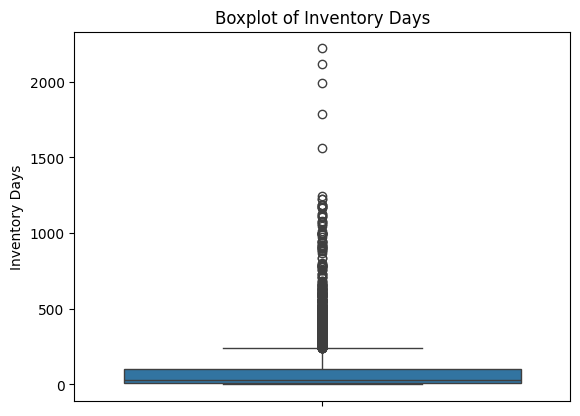

In [29]:
sns.boxplot(y = df['Inventory Days'])
plt.title('Boxplot of Inventory Days')
plt.show()

Finding suitable Threshold

In [17]:
median_inventory_days = df['Inventory Days'].median()
std_inventory_days = df['Inventory Days'].std()

threshold = median_inventory_days + 1.5 * std_inventory_days

Making sepearate Dataframe for slow-moving stock

In [18]:
slow_df = df[df['Inventory Days'] > threshold]
slow_df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Season,Inventory Days,Profitability
15,16,US-2015-118983,2015-11-22,2015-11-26,Standard Class,HP-14815,Harold Pawlan,Home Office,United States,Fort Worth,...,Office Supplies,Binders,Storex DuraTech Recycled Plastic Frosted Binders,2.544,3,0.8,-3.8160,Fall,344.339623,-150.00
30,31,US-2015-150630,2015-09-17,2015-09-21,Standard Class,TB-21520,Tracy Blumstein,Consumer,United States,Philadelphia,...,Office Supplies,Envelopes,Poly String Tie Envelopes,3.264,2,0.2,1.1016,Fall,253.190899,33.75
51,52,CA-2015-115742,2015-04-18,2015-04-22,Standard Class,DP-13000,Darren Powers,Consumer,United States,New Albany,...,Furniture,Furnishings,Longer-Life Soft White Bulbs,6.160,2,0.0,2.9568,Spring,512.768482,48.00
61,62,CA-2016-111682,2016-06-17,2016-06-18,First Class,TB-21055,Ted Butterfield,Consumer,United States,Troy,...,Office Supplies,Art,Prang Dustless Chalk Sticks,1.680,1,0.0,0.8400,Summer,434.523810,50.00
70,71,CA-2016-106075,2016-09-18,2016-09-23,Standard Class,HM-14980,Henry MacAllister,Consumer,United States,New York City,...,Office Supplies,Binders,Avery Binding System Hidden Tab Executive Styl...,4.616,1,0.2,1.7310,Fall,253.032929,37.50


Displaying Statistics

In [19]:
print("Median Inventory Days:", round(median_inventory_days, 2))
print("Standard Deviation of Inventory Days:", round(std_inventory_days, 2))
print("Threshold for slow-moving items:", round(threshold, 2))
print("Number of slow-moving items identified:", len(slow_df))

Median Inventory Days: 29.87
Standard Deviation of Inventory Days: 134.91
Threshold for slow-moving items: 232.24
Number of slow-moving items identified: 843


#Analysing Reasons for Overstocking


Assessing statistics of relevant columns

In [20]:
slow_df[['Sales', 'Profit', 'Discount', 'Inventory Days']].describe()

,Sales,Profit,Discount,Inventory Days
count,843.000000,843.000000,843.000000,843.000000
mean,6.775533,2.204885,0.152669,421.167521
std,4.199348,2.594967,0.221583,232.542007
min,0.444000,-6.930000,0.000000,232.263514
25%,3.596000,0.891000,0.000000,273.644009
50%,5.880000,2.006400,0.000000,343.162393
75%,8.820000,3.557250,0.200000,472.046706
max,28.350000,13.608000,0.800000,2221.545953


Classifying slow-moving items

In [34]:
#According to category
slow_df['Category'].value_counts()

,count
Category,
Office Supplies,766
Furniture,55
Technology,22


In [35]:
#According to sub-category
slow_df['Sub-Category'].value_counts()

,count
Sub-Category,
Binders,195
Art,166
Paper,137
Labels,114
Fasteners,95
Furnishings,55
Envelopes,30
Accessories,13
Appliances,12


In [36]:
#According to region
slow_df['Region'].value_counts()

,count
Region,
West,277
East,235
Central,193
South,138


Comparing Average Sales and Profitability

In [39]:
#For category
slow_df.groupby('Category')[['Sales', 'Profitability']].mean()

,Sales,Profitability
Category,,
Furniture,7.118327,23.140909
Office Supplies,6.802120,19.972367
Technology,4.992818,27.276515


In [40]:
#For sub-category
slow_df.groupby('Sub-Category')[['Sales', 'Profitability']].mean()

,Sales,Profitability
Sub-Category,,
Accessories,3.535077,29.711538
Appliances,4.551833,-27.583333
Art,5.766542,28.185241
Binders,5.300185,-21.495726
Envelopes,8.680667,42.525000
Fasteners,6.866737,33.568421
Furnishings,7.118327,23.140909
Labels,7.647404,42.532895
Paper,9.175620,41.693431


Plotting relationship between Discount and Profitability

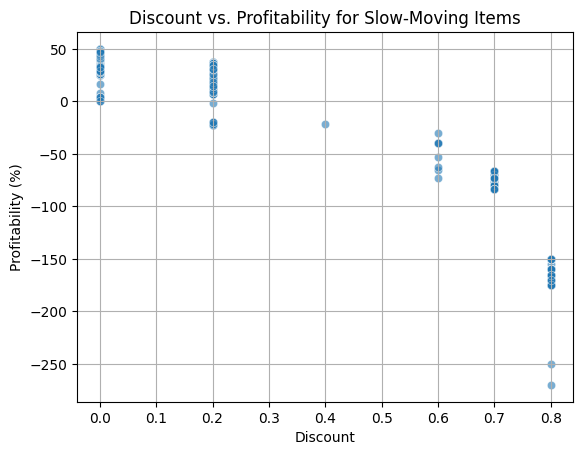

In [41]:
sns.scatterplot(x = 'Discount', y = 'Profitability', data = slow_df, alpha = 0.6)
plt.title('Discount vs. Profitability for Slow-Moving Items')
plt.xlabel('Discount')
plt.ylabel('Profitability (%)')
plt.grid(True)
plt.show()